In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import multiprocessing
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')
cores = multiprocessing.cpu_count()
os.listdir()

/home/nybsys/anaconda3/envs/nlp/lib/python3.7/site-packages/tqdm/std.py:656: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


['doc2vec.ipynb',
 'doc2vec_with_kfold.html',
 'doc2vec_with_kfold.ipynb',
 'kmeans_clustering.html',
 'kmeans_clustering.ipynb',
 'processed_dataset.csv',
 'readme.docx',
 'sentiment_analysis_from_story_preprocessing.html',
 'sentiment_analysis_from_story_preprocessing.ipynb',
 'sentiment_dictionary.csv',
 'word2vec.model',
 'Collective_Dataset',
 '.ipynb_checkpoints']

In [2]:
df = pd.read_csv(os.getcwd() + "/Collective_Dataset/419_data - Sheet1.csv", usecols=[0,1])#header=None, , names=['story', 'category']

In [3]:
df.head(10)

,story,category
0,"Just like any other day, employees arrived in ...",0
1,My so-called ‘friends’ in middle school used t...,1
2,i have been called hurtful names and i have be...,1
3,at my old school kids would hit me and call me...,1
4,I had debilitating migraines for three years b...,0
5,"I love my work, but hate going each day becaus...",0
6,I have a chronic illness which was doing well ...,0
7,The other part is that sense of worthlessness....,0
8,I feel my whole body hurting. My mental health...,0
9,"As a librarian, I've been threatened with stal...",2


In [4]:
df['story']

0      Just like any other day, employees arrived in ...
1      My so-called ‘friends’ in middle school used t...
2      i have been called hurtful names and i have be...
3      at my old school kids would hit me and call me...
4      I had debilitating migraines for three years b...
                             ...                        
265    I worked at a call center for over 5 years. It...
266    I work in a call center as a supervisor. That ...
267    I too went throygh a tough 18 month period of ...
268    I was employed as a testing Co-ordinator on a ...
269    I'm also an injured worker. My workplace havin...
Name: story, Length: 270, dtype: object

In [5]:
df['category']

0      0
1      1
2      1
3      1
4      0
      ..
265    0
266    0
267    0
268    0
269    0
Name: category, Length: 270, dtype: int64

In [6]:
df.shape

(270, 2)

In [8]:
df.index = range(270)

In [9]:
df.story.apply(lambda x: len(x.split(' '))).sum()

50346

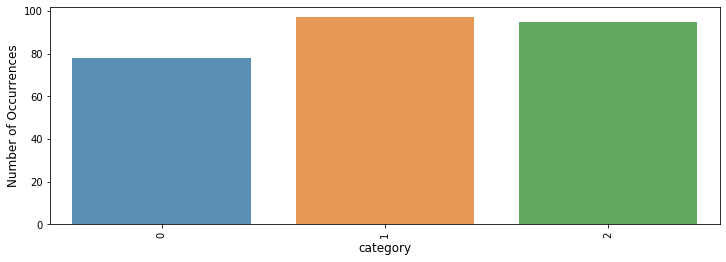

In [10]:
cnt_pro = df['category'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [11]:
work_stress_counter, bullying_counter, sexual_harassment_counter = 0, 0, 0
for c in df['category']:
    if c==0:
        work_stress_counter+=1
    elif c == 1:
        bullying_counter+=1
    else:
        sexual_harassment_counter+=1
print("Work Stress Total Data Count: ", work_stress_counter)
print("Bullying Total Data Count: ", bullying_counter)
print("Sexual Harassment Total Data Count: ", sexual_harassment_counter)

Work Stress Total Data Count:  78
Bullying Total Data Count:  97
Sexual Harassment Total Data Count:  95


In [12]:
print(df.story[2])
print(df.category[2])

i have been called hurtful names and i have been called black bitch and people are making fun of me for being black by my suppost to be friend t and she has posted rumors about me and i dont know what to do.
1


In [13]:
print(df.story[0])
print(df.category[0])

Just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. Once more, the manager was already sitting at his desk, grumbling and shouting - You’re way too slow, again! How am I supposed to get my work done with you slowing me down every day? The other employees were staring at each other. They were embarrassed by his outburst but deep inside they knew he was right. Satisfied by the nods in the assembly, the manager calmed down. As usual, he quickly got absorbed by his screen and numerous emails. He was not the moody type, just a normal guy. His team liked him very much and his performance record was exemplary. He was often described as someone caring and trustworthy with a genuine interest in people. Yet once again, his fist hit the desk loudly as he started screaming. That’s it, I’m done! Slow and unreliable old crap! You made me lose five hours of my life, again. World will be better off without you and I’m going to le

In [14]:
print(df.story[10])
print(df.category[10])

I worked as an office manager, and the only woman, for an industrial insulation company. I had just come back from maternity leave and I was worried about my milk supply. I went into the bathroom to pump for about 15 minutes every two hours, and all of the men in the office would stand in the break area (right in front of the bathroom door) and make baby crying noises to make fun of me. Eventually it progressed to the point that they would make crying noises every time they passed my desk in hopes that I would leak through my shirt. They would also make comments about how much larger my breasts were since having a baby. I felt so harassed and unsafe that I would dread going to work every day, and I even had more than a few nervous breakdowns. My husband was furious and I had to convince him not to take any drastic action so that I could be sure to have a good reference if I needed to find another job. We had a long conversation and looked at our finances and decided the extra money was

In [15]:
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['story'] = df['story'].apply(cleanText)

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

### WITH TRAIN_TEST_SPLIT

In [17]:
train, test = train_test_split(df, test_size = .20, random_state = 2)

In [18]:
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)

In [19]:
train

,story,category
134,i'm 16 and a boy. i really don't know how to d...,2
101,"hello! first of all, i'm sorry if there are a ...",1
127,eleven years ago i was seually harassed by a t...,2
197,i had been seeing this guy for just over three...,2
24,high school and junior high were hell for me. ...,1
...,...,...
75,i’m in the 8th grade. ever since i started mid...,1
22,"hi, i'm rahul. i was bullied all through schoo...",1
72,"when i was in 7th grade, i had a semester of m...",1
15,"i got made fun of for being fat in elementary,...",1


In [20]:
len(train)

216

In [21]:
test

,story,category
131,my boyfriend and i were watching a movie in hi...,2
183,a male customer stalked me for several weeks l...,2
200,i was very young and i don’t remember much. he...,2
65,i was most definitely bullied in my high schoo...,1
91,i am 14 years old and in the 8th grade. i have...,1
115,"and im 14 years old. all my life, i been bulli...",1
93,i have a weird name. i don't even know why i h...,1
242,being a single mother is one of the most stres...,0
29,i was in class 11. i was coming back from my t...,1
3,at my old school kids would hit me and call me...,1


In [22]:
len(test)

54

In [23]:
train_tagged

134    (['m, 16, and, boy, really, do, n't, know, how...
101    ([hello, first, of, all, 'm, sorry, if, there,...
127    ([eleven, years, ago, was, seually, harassed, ...
197    ([had, been, seeing, this, guy, for, just, ove...
24     ([high, school, and, junior, high, were, hell,...
                             ...                        
75     ([in, the, 8th, grade, ever, since, started, m...
22     ([hi, 'm, rahul, was, bullied, all, through, s...
72     ([when, was, in, 7th, grade, had, semester, of...
15     ([got, made, fun, of, for, being, fat, in, ele...
168    ([let, me, tell, you, about, few, of, my, eper...
Length: 216, dtype: object

In [24]:
train_tagged.values[2]

TaggedDocument(words=['eleven', 'years', 'ago', 'was', 'seually', 'harassed', 'by', 'teenage', 'boy', 'whom', 'trusted', 'and', 'was', 'very', 'close', 'to', 'we', 'were', 'in', 'his', 'basement', 'playing', 'ping', 'pong', 'and', 'some', 'other', 'boys', 'were', 'there', 'too', 'once', 'they', 'left', 'to', 'go', 'upstairs', 'he', 'started', 'asking', 'me', 'if', 'could', 'unzip', 'my', 'pants', 'was', 'seven', 'years', 'old', 'at', 'the', 'time', 'so', 'only', 'remember', 'chunks', 'of', 'what', 'happened', 'but', 'the', 'one', 'thing', 'remember', 'very', 'clearly', 'was', 'when', 'he', 'rubbed', 'his', 'finger', 'very', 'gently', 'over', 'the', 'skin', 'that', 'was', 'beneath', 'my', 'underpants', 'remember', 'just', 'standing', 'there', 'frozen', 'and', 'feeling', 'confused', 'that', 'night', 'remember', 'laying', 'in', 'bed', 'net', 'to', 'my', 'mom', 'and', 'thought', 'to', 'myself', 'do', 'tell', 'her', 'what', 'do', 'say', 'later', 'that', 'night', 'told', 'my', 'parents', 'wh

In [25]:
test_tagged.values[1]

TaggedDocument(words=['male', 'customer', 'stalked', 'me', 'for', 'several', 'weeks', 'late', 'last', 'year', 'culminating', 'in', 'an', 'incident', 'where', 'he', 'followed', 'me', 'around', 'the', 'shop', 'shortly', 'before', 'close', 'casually', 'showing', 'me', 'what', 'appeared', 'to', 'be', 'gun', 'tucked', 'into', 'his', 'waistband', 'some', 'of', 'my', 'male', 'coworkers', 'told', 'me', 'was', 'eaggerating', 'or', 'that', 'the', 'guy', 'wasn', 'so', 'bad', 'another', 'my', 'manager', 'at', 'the', 'time', 'and', 'one', 'of', 'the', 'best', 'men', 've', 'ever', 'known', 'bought', 'me', 'knife', 'and', 'taught', 'me', 'how', 'to', 'use', 'it', 'when', 'told', 'him', 'what', 'had', 'happened'], tags=[2])

### PV-DBOW

In [26]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 216/216 [00:00<00:00, 643901.68it/s]


In [27]:
%%time
for epoch in range(5):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 216/216 [00:00<00:00, 1225940.01it/s]

CPU times: user 389 ms, sys: 17.4 ms, total: 406 ms
Wall time: 183 ms


In [28]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [29]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [30]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [31]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8518518518518519
Testing F1 score: 0.8513733371614509

Testing Confusion Matrix: 
[[ 8  1  1]
 [ 0 20  2]
 [ 2  2 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        10
           1       0.87      0.91      0.89        22
           2       0.86      0.82      0.84        22

    accuracy                           0.85        54
   macro avg       0.84      0.84      0.84        54
weighted avg       0.85      0.85      0.85        54



### PV-DM

In [32]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 216/216 [00:00<00:00, 1532943.59it/s]


In [33]:
%%time
for epoch in range(5):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 216/216 [00:00<00:00, 163208.37it/s]


CPU times: user 523 ms, sys: 17.9 ms, total: 541 ms
Wall time: 301 ms


In [34]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

In [35]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [36]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8518518518518519
Testing F1 score: 0.8507970833002446

Testing Confusion Matrix: 
[[ 7  3  0]
 [ 0 20  2]
 [ 1  2 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.80      0.91      0.85        22
           2       0.90      0.86      0.88        22

    accuracy                           0.85        54
   macro avg       0.86      0.82      0.84        54
weighted avg       0.86      0.85      0.85        54



### Paired Model

In [37]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [38]:
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [39]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [40]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [41]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [42]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
print('\nTesting Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred),"\n")
print('Testing Classification Report: ')
print(classification_report(y_test, y_pred))

Testing accuracy 0.8148148148148148
Testing F1 score: 0.806561996779388

Testing Confusion Matrix: 
[[ 5  2  3]
 [ 0 20  2]
 [ 1  2 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.50      0.62        10
           1       0.83      0.91      0.87        22
           2       0.79      0.86      0.83        22

    accuracy                           0.81        54
   macro avg       0.82      0.76      0.77        54
weighted avg       0.82      0.81      0.81        54



### WITH K-FOLD

In [43]:
X = df['story']
print("Length: ", len(X))
print("Type: ", type(X))
print("First Ten Values:\n", X[:10])
print(X[0])

Length:  270
Type:  <class 'pandas.core.series.Series'>
First Ten Values:
 0    just like any other day, employees arrived in ...
1    my so-called ‘friends’ in middle school used t...
2    i have been called hurtful names and i have be...
3    at my old school kids would hit me and call me...
4    i had debilitating migraines for three years b...
5    i love my work, but hate going each day becaus...
6    i have a chronic illness which was doing well ...
7    the other part is that sense of worthlessness....
8    i feel my whole body hurting. my mental health...
9    as a librarian, i've been threatened with stal...
Name: story, dtype: object
just like any other day, employees arrived in the workplace sparingly, filling the cubicles and getting their coffees ready. once more, the manager was already sitting at his desk, grumbling and shouting - you’re way too slow, again! how am i supposed to get my work done with you slowing me down every day? the other employees were staring at each

In [44]:
y = df['category']
print("Length: ", len(y))
print("Type: ", type(y))
print("First Ten Values: ", y[:10])

Length:  270
Type:  <class 'pandas.core.series.Series'>
First Ten Values:  0    0
1    1
2    1
3    1
4    0
5    0
6    0
7    0
8    0
9    2
Name: category, dtype: int64


In [45]:
ten_fold = KFold(n_splits=5, shuffle = True, random_state=42)
ten_fold

KFold(n_splits=5, random_state=42, shuffle=True)

In [46]:
print("Total Fold: ", ten_fold.get_n_splits(X))
fold_no = 1
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

Total Fold:  5
X_train:  (216,) X_test:  (54,)
X_train:  (216,) X_test:  (54,)
X_train:  (216,) X_test:  (54,)
X_train:  (216,) X_test:  (54,)
X_train:  (216,) X_test:  (54,)


In [47]:
total_fold = ten_fold.get_n_splits(X)
print(total_fold)

5


### K-FOLD PV-DBOW

In [48]:
print("Total Fold: ", total_fold)
fold_no = 1
for train_index, test_index in ten_fold.split(X):
    print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold: ", fold_no, "", len(X_train))
    print("No. of Testing Dataset in Fold: ", fold_no, "", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    
    print("\n\n")
    fold_no+=1

Total Fold:  5
Train Fold No.:  [  0   1   2   3   4   5   7   8  10  11  12  13  14  16  17  18  20  21
  23  26  27  28  29  31  32  33  34  35  36  37  38  39  40  41  43  44
  47  48  49  50  51  52  53  54  55  56  57  58  59  61  62  63  64  65
  66  69  70  71  72  73  74  75  76  78  80  81  83  84  85  86  87  88
  89  91  92  94  95  96  97  98  99 100 101 102 103 105 106 107 108 110
 111 112 114 115 117 121 122 123 124 126 128 129 130 131 132 133 134 135
 136 138 139 140 141 142 143 145 147 148 149 150 151 153 154 155 156 157
 159 160 161 162 163 164 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 181 182 184 186 187 188 189 190 191 192 193 195 197 198 200 201
 202 203 204 205 206 207 210 211 212 213 214 215 217 218 219 220 222 223
 225 228 229 230 231 233 234 235 236 237 238 239 240 241 242 243 245 246
 248 249 251 253 254 255 256 257 258 259 260 261 262 263 264 265 267 269]  Test Fold No.:  [  6   9  15  19  22  24  25  30  42  45  46  60  67  68  77  79  82  90
 

100%|██████████| 216/216 [00:00<00:00, 1374764.29it/s]


Fold No.:  1
Testing accuracy 0.8703703703703703
Testing F1 score: 0.870320589406611

Testing Confusion Matrix: 
[[14  2  2]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.83      0.95      0.89        21
           2       0.81      0.87      0.84        15

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54




Train Fold No.:  [  0   1   3   4   5   6   7   8   9  11  12  13  14  15  17  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  34  35  36  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59  60  61
  62  63  64  65  67  68  70  71  72  77  79  80  81  82  83  85  87  88
  89  90  91  93  94  95  98  99 100 102 103 104 105 106 107 109 110 113
 114 116 117 118 119 120 121 122 123 125 127 128 1

100%|██████████| 216/216 [00:00<00:00, 1263556.02it/s]


Fold No.:  2
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9085317907495054

Testing Confusion Matrix: 
[[12  2  0]
 [ 1 21  0]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.91      0.95      0.93        22
           2       1.00      0.89      0.94        18

    accuracy                           0.91        54
   macro avg       0.90      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54




Train Fold No.:  [  1   2   3   6   7   8   9  10  13  14  15  16  17  18  19  20  21  22
  23  24  25  30  33  34  37  38  39  40  42  43  44  45  46  47  48  49
  50  52  53  54  55  57  58  59  60  62  63  64  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  86  87  88  89  90
  91  92  93  94  96  97  99 101 102 103 104 105 106 107 108 109 110 111
 112 113 115 116 118 119 120 121 123 124 125 126 

100%|██████████| 216/216 [00:00<00:00, 195716.06it/s]


Fold No.:  3
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8515432098765432

Testing Confusion Matrix: 
[[12  0  3]
 [ 2 13  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       1.00      0.76      0.87        17
           2       0.81      0.95      0.88        22

    accuracy                           0.85        54
   macro avg       0.87      0.84      0.85        54
weighted avg       0.87      0.85      0.85        54




Train Fold No.:  [  0   2   4   5   6   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  24  25  26  27  28  29  30  31  32  33  35  36  37  38  41  42
  45  46  48  50  51  52  54  55  56  57  58  59  60  61  63  65  66  67
  68  69  71  72  73  74  75  76  77  78  79  82  84  85  86  87  88  89
  90  92  93  95  96  97  98  99 100 101 102 104 106 107 108 109 111 112
 113 114 115 116 117 118 119 120 121 122 124 125 

100%|██████████| 216/216 [00:00<00:00, 1422244.37it/s]


Fold No.:  4
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8671700264239719

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 15  1]
 [ 3  3 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      1.00      0.91        15
           1       0.83      0.94      0.88        16
           2       0.94      0.74      0.83        23

    accuracy                           0.87        54
   macro avg       0.87      0.89      0.87        54
weighted avg       0.88      0.87      0.87        54




Train Fold No.:  [  0   1   2   3   4   5   6   7   9  10  11  12  15  16  18  19  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  49  51  53  55  56  60  61  62  64  65  66  67
  68  69  70  73  74  75  76  77  78  79  80  81  82  83  84  85  86  90
  91  92  93  94  95  96  97  98 100 101 103 104 105 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 124 125 

100%|██████████| 216/216 [00:00<00:00, 937856.80it/s]


Fold No.:  5
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8327721661054994

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 18  2]
 [ 2  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.86      0.86      0.86        21
           2       0.81      0.76      0.79        17

    accuracy                           0.83        54
   macro avg       0.83      0.83      0.83        54
weighted avg       0.83      0.83      0.83        54






### K-FOLD PV-DM 

In [49]:
fold_no = 1
print("Total Fold: ", total_fold)
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg = LogisticRegression(n_jobs=1, C=1e5)
    logreg.fit(X_trained, y_trained)
    y_pred = logreg.predict(X_tested)
    
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    print("\n\n")
    fold_no+=1

Total Fold:  5
No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 161175.89it/s]


Fold No.:  1
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8304550885196046

Testing Confusion Matrix: 
[[12  2  4]
 [ 0 20  1]
 [ 1  1 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.92      0.67      0.77        18
           1       0.87      0.95      0.91        21
           2       0.72      0.87      0.79        15

    accuracy                           0.83        54
   macro avg       0.84      0.83      0.82        54
weighted avg       0.85      0.83      0.83        54




No. of Training Dataset in Fold  2 :  216
No. of Testing Dataset in Fold  2 :  54


100%|██████████| 216/216 [00:00<00:00, 1482765.41it/s]


Fold No.:  2
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8499473832807166

Testing Confusion Matrix: 
[[10  1  3]
 [ 0 21  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.91      0.95      0.93        22
           2       0.79      0.83      0.81        18

    accuracy                           0.85        54
   macro avg       0.85      0.83      0.84        54
weighted avg       0.85      0.85      0.85        54




No. of Training Dataset in Fold  3 :  216
No. of Testing Dataset in Fold  3 :  54


100%|██████████| 216/216 [00:00<00:00, 1581098.89it/s]


Fold No.:  3
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8895405669599218

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 15  0]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.94      0.88      0.91        17
           2       0.91      0.91      0.91        22

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.89        54
weighted avg       0.89      0.89      0.89        54




No. of Training Dataset in Fold  4 :  216
No. of Testing Dataset in Fold  4 :  54


100%|██████████| 216/216 [00:00<00:00, 171487.73it/s]


Fold No.:  4
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8298941798941799

Testing Confusion Matrix: 
[[11  0  4]
 [ 0 16  0]
 [ 2  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.84      1.00      0.91        16
           2       0.82      0.78      0.80        23

    accuracy                           0.83        54
   macro avg       0.84      0.84      0.83        54
weighted avg       0.83      0.83      0.83        54




No. of Training Dataset in Fold  5 :  216
No. of Testing Dataset in Fold  5 :  54


100%|██████████| 216/216 [00:00<00:00, 532923.33it/s]


Fold No.:  5
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8515169617320155

Testing Confusion Matrix: 
[[14  1  1]
 [ 0 19  2]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.83      0.90      0.86        21
           2       0.81      0.76      0.79        17

    accuracy                           0.85        54
   macro avg       0.86      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54






### PAIRED MODEL

In [50]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    logreg_dbow = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dbow.fit(X_trained, y_trained)
    y_pred = logreg_dbow.predict(X_tested)
    
    print("FOR PV_DBOW: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    logreg_dm = LogisticRegression(n_jobs=1, C=1e5)
    logreg_dm.fit(X_trained, y_trained)
    y_pred = logreg_dm.predict(X_tested)
    
    print("FOR PV_DM: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    logreg_paired = LogisticRegression(n_jobs=1, C=1e5)
    logreg_paired.fit(X_train, y_train)
    y_pred = logreg_paired.predict(X_test)
    
    print("FOR Paired Model: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 1268865.08it/s]

FOR PV_DBOW: 
Fold No.:  1
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8894500561167228

Testing Confusion Matrix: 
[[15  2  1]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.83      0.95      0.89        21
           2       0.87      0.87      0.87        15

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.89        54
weighted avg       0.90      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 741989.90it/s]


FOR PV_DM: 
Fold No.:  1
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8700851683509112

Testing Confusion Matrix: 
[[13  1  4]
 [ 0 20  1]
 [ 0  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.91      0.95      0.93        21
           2       0.74      0.93      0.82        15

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.86        54
weighted avg       0.89      0.87      0.87        54




FOR Paired Model: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8708964646464645

Testing Confusion Matrix: 
[[14  1  3]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.87      0.95      0.91        21
           2       0.76      0.87      0.81        15

    accura

100%|██████████| 216/216 [00:00<00:00, 1378949.26it/s]

FOR PV_DBOW: 
Fold No.:  2
Testing accuracy 0.8703703703703703
Testing F1 score: 0.869906943981018

Testing Confusion Matrix: 
[[11  2  1]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.91      0.91      0.91        22
           2       0.84      0.89      0.86        18

    accuracy                           0.87        54
   macro avg       0.87      0.86      0.86        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1048576.00it/s]


FOR PV_DM: 
Fold No.:  2
Testing accuracy 0.8333333333333334
Testing F1 score: 0.825839217143565

Testing Confusion Matrix: 
[[ 8  2  4]
 [ 0 21  1]
 [ 1  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.57      0.70        14
           1       0.88      0.95      0.91        22
           2       0.76      0.89      0.82        18

    accuracy                           0.83        54
   macro avg       0.84      0.80      0.81        54
weighted avg       0.84      0.83      0.83        54




FOR Paired Model: 
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8289176132654394

Testing Confusion Matrix: 
[[ 9  2  3]
 [ 0 21  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.88      0.95      0.91        22
           2       0.79      0.83      0.81        18

    accurac

100%|██████████| 216/216 [00:00<00:00, 1402429.82it/s]

FOR PV_DBOW: 
Fold No.:  3
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8698806104205327

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 13  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.76      0.87        17
           2       0.84      0.95      0.89        22

    accuracy                           0.87        54
   macro avg       0.88      0.86      0.87        54
weighted avg       0.88      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1224283.33it/s]


FOR PV_DM: 
Fold No.:  3
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8893044517167938

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 14  1]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.82      0.90        17
           2       0.88      0.95      0.91        22

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.88        54
weighted avg       0.90      0.89      0.89        54




FOR Paired Model: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8893044517167938

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 14  1]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.82      0.90        17
           2       0.88      0.95      0.91        22

    accura

100%|██████████| 216/216 [00:00<00:00, 1442626.85it/s]

FOR PV_DBOW: 
Fold No.:  4
Testing accuracy 0.9074074074074074
Testing F1 score: 0.90981704200095

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 0  4 19]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.76      1.00      0.86        16
           2       1.00      0.83      0.90        23

    accuracy                           0.91        54
   macro avg       0.92      0.92      0.91        54
weighted avg       0.93      0.91      0.91        54







100%|██████████| 216/216 [00:00<00:00, 1249613.33it/s]


FOR PV_DM: 
Fold No.:  4
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9078189300411523

Testing Confusion Matrix: 
[[12  2  1]
 [ 0 16  0]
 [ 0  2 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.80      1.00      0.89        16
           2       0.95      0.91      0.93        23

    accuracy                           0.91        54
   macro avg       0.92      0.90      0.90        54
weighted avg       0.92      0.91      0.91        54




FOR Paired Model: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8708089668615984

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 1  5 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.73      1.00      0.84        16
           2       1.00      0.74      0.85        23

    accura

100%|██████████| 216/216 [00:00<00:00, 1473121.40it/s]

FOR PV_DBOW: 
Fold No.:  5
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8521255919629903

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 18  2]
 [ 2  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        16
           1       0.90      0.86      0.88        21
           2       0.82      0.82      0.82        17

    accuracy                           0.85        54
   macro avg       0.85      0.85      0.85        54
weighted avg       0.85      0.85      0.85        54







100%|██████████| 216/216 [00:00<00:00, 1239356.59it/s]


FOR PV_DM: 
Fold No.:  5
Testing accuracy 0.7777777777777778
Testing F1 score: 0.7792181069958848

Testing Confusion Matrix: 
[[13  1  2]
 [ 1 16  4]
 [ 2  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.84      0.76      0.80        21
           2       0.68      0.76      0.72        17

    accuracy                           0.78        54
   macro avg       0.78      0.78      0.78        54
weighted avg       0.78      0.78      0.78        54




FOR Paired Model: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8695847362514029

Testing Confusion Matrix: 
[[13  2  1]
 [ 0 20  1]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.81      0.87        16
           1       0.83      0.95      0.89        21
           2       0.88      0.82      0.85        17

    accura

### Decision Tree Using Entropy

In [51]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Entropy: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Entropy:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "entropy", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Entropy: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 594858.61it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  1
Testing accuracy 0.8703703703703703
Testing F1 score: 0.870320589406611

Testing Confusion Matrix: 
[[14  2  2]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.78      0.88        18
           1       0.83      0.95      0.89        21
           2       0.81      0.87      0.84        15

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1487634.92it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  1
Testing accuracy 0.9259259259259259
Testing F1 score: 0.9254307783719548

Testing Confusion Matrix: 
[[15  3  0]
 [ 1 20  0]
 [ 0  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.87      0.95      0.91        21
           2       1.00      1.00      1.00        15

    accuracy                           0.93        54
   macro avg       0.94      0.93      0.93        54
weighted avg       0.93      0.93      0.93        54




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.9259259259259259
Testing F1 score: 0.9254307783719548

Testing Confusion Matrix: 
[[15  3  0]
 [ 1 20  0]
 [ 0  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.87      0.95      0.91        2

100%|██████████| 216/216 [00:00<00:00, 1332308.33it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  2
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8713207995485461

Testing Confusion Matrix: 
[[12  1  1]
 [ 0 20  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.95      0.91      0.93        22
           2       0.83      0.83      0.83        18

    accuracy                           0.87        54
   macro avg       0.86      0.87      0.86        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 608033.33it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  2
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8323169681309216

Testing Confusion Matrix: 
[[ 9  1  4]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.95      0.91      0.93        22
           2       0.73      0.89      0.80        18

    accuracy                           0.83        54
   macro avg       0.83      0.81      0.82        54
weighted avg       0.84      0.83      0.83        54




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8323169681309216

Testing Confusion Matrix: 
[[ 9  1  4]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        14
           1       0.95      0.91      0.93        2

100%|██████████| 216/216 [00:00<00:00, 553432.90it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  3
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8694142142876552

Testing Confusion Matrix: 
[[12  1  2]
 [ 1 14  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.93      0.82      0.87        17
           2       0.84      0.95      0.89        22

    accuracy                           0.87        54
   macro avg       0.88      0.86      0.87        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1001071.45it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  3
Testing accuracy 0.8148148148148148
Testing F1 score: 0.818342151675485

Testing Confusion Matrix: 
[[12  2  1]
 [ 2 14  1]
 [ 4  0 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.88      0.82      0.85        17
           2       0.90      0.82      0.86        22

    accuracy                           0.81        54
   macro avg       0.81      0.81      0.81        54
weighted avg       0.83      0.81      0.82        54




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8148148148148148
Testing F1 score: 0.818342151675485

Testing Confusion Matrix: 
[[12  2  1]
 [ 2 14  1]
 [ 4  0 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.67      0.80      0.73        15
           1       0.88      0.82      0.85        17


100%|██████████| 216/216 [00:00<00:00, 558550.96it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  4
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8676651739779431

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 15  1]
 [ 4  2 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       0.88      0.94      0.91        16
           2       0.94      0.74      0.83        23

    accuracy                           0.87        54
   macro avg       0.87      0.89      0.87        54
weighted avg       0.88      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 803877.25it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  4
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8894992553529141

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 1  4 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.76      1.00      0.86        16
           2       1.00      0.78      0.88        23

    accuracy                           0.89        54
   macro avg       0.90      0.91      0.89        54
weighted avg       0.91      0.89      0.89        54




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8894992553529141

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 1  4 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.76      1.00      0.86        1

100%|██████████| 216/216 [00:00<00:00, 661774.77it/s]

FOR PV_DBOW Using Decision Tree with Entropy: 
Fold No.:  5
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8690885105535643

Testing Confusion Matrix: 
[[14  1  1]
 [ 0 20  1]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.83      0.95      0.89        21
           2       0.87      0.76      0.81        17

    accuracy                           0.87        54
   macro avg       0.88      0.86      0.87        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1033032.68it/s]


FOR PV_DM Using Decision Tree with Entropy:  
Fold No.:  5
Testing accuracy 0.7962962962962963
Testing F1 score: 0.792552767821585

Testing Confusion Matrix: 
[[13  2  1]
 [ 0 19  2]
 [ 3  3 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.79      0.90      0.84        21
           2       0.79      0.65      0.71        17

    accuracy                           0.80        54
   macro avg       0.80      0.79      0.79        54
weighted avg       0.80      0.80      0.79        54




FOR Paired Model Using Decision Tree with Entropy: 
Testing accuracy 0.7962962962962963
Testing F1 score: 0.792552767821585

Testing Confusion Matrix: 
[[13  2  1]
 [ 0 19  2]
 [ 3  3 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.79      0.90      0.84        21


### Decision Tree Using Gini

In [52]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DBOW Using Decision Tree with Gini: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR PV_DM Using Decision Tree with Gini:  ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    dt_dbow_entropy = DecisionTreeClassifier(criterion = "gini", 
                                             random_state = 10, 
                                             max_depth = 3, 
                                             min_samples_leaf = 5)
    dt_dbow_entropy.fit(X_trained, y_trained)
    y_pred = dt_dbow_entropy.predict(X_tested)
    
    print("FOR Paired Model Using Decision Tree with Gini: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 603979.78it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  1
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8903248167954051

Testing Confusion Matrix: 
[[16  2  0]
 [ 0 19  2]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        18
           1       0.83      0.90      0.86        21
           2       0.87      0.87      0.87        15

    accuracy                           0.89        54
   macro avg       0.90      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 535759.71it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  1
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8674242424242423

Testing Confusion Matrix: 
[[13  3  2]
 [ 0 20  1]
 [ 1  0 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.87      0.95      0.91        21
           2       0.82      0.93      0.87        15

    accuracy                           0.87        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.88      0.87      0.87        54




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8674242424242423

Testing Confusion Matrix: 
[[13  3  2]
 [ 0 20  1]
 [ 1  0 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.72      0.81        18
           1       0.87      0.95      0.91        21
    

100%|██████████| 216/216 [00:00<00:00, 610080.58it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  2
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8505023241865346

Testing Confusion Matrix: 
[[10  2  2]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.91      0.91      0.91        22
           2       0.80      0.89      0.84        18

    accuracy                           0.85        54
   macro avg       0.85      0.84      0.84        54
weighted avg       0.85      0.85      0.85        54







100%|██████████| 216/216 [00:00<00:00, 1408973.04it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  2
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8692729766803841

Testing Confusion Matrix: 
[[11  1  2]
 [ 0 21  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.91      0.95      0.93        22
           2       0.83      0.83      0.83        18

    accuracy                           0.87        54
   macro avg       0.86      0.86      0.86        54
weighted avg       0.87      0.87      0.87        54




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8692729766803841

Testing Confusion Matrix: 
[[11  1  2]
 [ 0 21  1]
 [ 2  1 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.79      0.81        14
           1       0.91      0.95      0.93        22
    

100%|██████████| 216/216 [00:00<00:00, 474826.87it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  3
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8499927903431796

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 12  3]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.71      0.83        17
           2       0.81      0.95      0.88        22

    accuracy                           0.85        54
   macro avg       0.87      0.84      0.85        54
weighted avg       0.87      0.85      0.85        54







100%|██████████| 216/216 [00:00<00:00, 1246175.60it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  3
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8499927903431796

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 12  3]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.71      0.83        17
           2       0.81      0.95      0.88        22

    accuracy                           0.85        54
   macro avg       0.87      0.84      0.85        54
weighted avg       0.87      0.85      0.85        54




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8499927903431796

Testing Confusion Matrix: 
[[13  0  2]
 [ 2 12  3]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       1.00      0.71      0.83        17
    

100%|██████████| 216/216 [00:00<00:00, 911438.29it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  4
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8868748933265062

Testing Confusion Matrix: 
[[14  0  1]
 [ 0 16  0]
 [ 2  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.84      1.00      0.91        16
           2       0.95      0.78      0.86        23

    accuracy                           0.89        54
   macro avg       0.89      0.91      0.89        54
weighted avg       0.90      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 1461241.39it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  4
Testing accuracy 0.7777777777777778
Testing F1 score: 0.7804017722716909

Testing Confusion Matrix: 
[[10  3  2]
 [ 0 16  0]
 [ 0  7 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.62      1.00      0.76        16
           2       0.89      0.70      0.78        23

    accuracy                           0.78        54
   macro avg       0.83      0.79      0.78        54
weighted avg       0.84      0.78      0.78        54




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.7777777777777778
Testing F1 score: 0.7804017722716909

Testing Confusion Matrix: 
[[10  3  2]
 [ 0 16  0]
 [ 0  7 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        15
           1       0.62      1.00      0.76        16
    

100%|██████████| 216/216 [00:00<00:00, 1312999.51it/s]

FOR PV_DBOW Using Decision Tree with Gini: 
Fold No.:  5
Testing accuracy 0.8148148148148148
Testing F1 score: 0.8148148148148148

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 17  3]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.81      0.81      0.81        21
           2       0.76      0.76      0.76        17

    accuracy                           0.81        54
   macro avg       0.82      0.82      0.82        54
weighted avg       0.81      0.81      0.81        54







100%|██████████| 216/216 [00:00<00:00, 1348169.14it/s]


FOR PV_DM Using Decision Tree with Gini:  
Fold No.:  5
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8897690794242519

Testing Confusion Matrix: 
[[13  1  2]
 [ 0 19  2]
 [ 0  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.90      0.90      0.90        21
           2       0.80      0.94      0.86        17

    accuracy                           0.89        54
   macro avg       0.90      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54




FOR Paired Model Using Decision Tree with Gini: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8897690794242519

Testing Confusion Matrix: 
[[13  1  2]
 [ 0 19  2]
 [ 0  1 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.90      0.90      0.90        21
    

### K Nearest Neighbour with Minkowski Distance

In [53]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Minkowski Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Minkowski Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 573398.52it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8888388049983723

Testing Confusion Matrix: 
[[15  2  1]
 [ 1 20  0]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.83      0.95      0.89        21
           2       0.93      0.87      0.90        15

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.89        54
weighted avg       0.89      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 1387396.12it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  1
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8897551092318534

Testing Confusion Matrix: 
[[15  2  1]
 [ 0 19  2]
 [ 0  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.86      0.90      0.88        21
           2       0.82      0.93      0.87        15

    accuracy                           0.89        54
   macro avg       0.90      0.89      0.89        54
weighted avg       0.90      0.89      0.89        54




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8897551092318534

Testing Confusion Matrix: 
[[15  2  1]
 [ 0 19  2]
 [ 0  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        18
           1       0.86      0.90      0.88        

100%|██████████| 216/216 [00:00<00:00, 472105.09it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.9259259259259259
Testing F1 score: 0.9260901295384053

Testing Confusion Matrix: 
[[13  1  0]
 [ 0 21  1]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.95      0.95      0.95        22
           2       0.94      0.89      0.91        18

    accuracy                           0.93        54
   macro avg       0.92      0.92      0.92        54
weighted avg       0.93      0.93      0.93        54







100%|██████████| 216/216 [00:00<00:00, 1152633.16it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  2
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8515579071134627

Testing Confusion Matrix: 
[[11  3  0]
 [ 0 20  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.87      0.91      0.89        22
           2       0.88      0.83      0.86        18

    accuracy                           0.85        54
   macro avg       0.85      0.84      0.84        54
weighted avg       0.85      0.85      0.85        54




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8515579071134627

Testing Confusion Matrix: 
[[11  3  0]
 [ 0 20  2]
 [ 3  0 15]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.79      0.79        14
           1       0.87      0.91      0.89        

100%|██████████| 216/216 [00:00<00:00, 887335.62it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8503266478558174

Testing Confusion Matrix: 
[[12  1  2]
 [ 2 13  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        15
           1       0.93      0.76      0.84        17
           2       0.84      0.95      0.89        22

    accuracy                           0.85        54
   macro avg       0.86      0.84      0.84        54
weighted avg       0.86      0.85      0.85        54







100%|██████████| 216/216 [00:00<00:00, 598394.76it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  3
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9066059338908801

Testing Confusion Matrix: 
[[14  1  0]
 [ 1 14  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.93      0.82      0.87        17
           2       0.91      0.95      0.93        22

    accuracy                           0.91        54
   macro avg       0.91      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9066059338908801

Testing Confusion Matrix: 
[[14  1  0]
 [ 1 14  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.93      0.82      0.87        

100%|██████████| 216/216 [00:00<00:00, 1091529.72it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8691893506409635

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 2  4 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.76      1.00      0.86        16
           2       1.00      0.74      0.85        23

    accuracy                           0.87        54
   macro avg       0.88      0.89      0.87        54
weighted avg       0.89      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 960731.35it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  4
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8858281893004116

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 16  0]
 [ 2  4 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       0.80      1.00      0.89        16
           2       1.00      0.74      0.85        23

    accuracy                           0.89        54
   macro avg       0.89      0.91      0.89        54
weighted avg       0.91      0.89      0.89        54




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8858281893004116

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 16  0]
 [ 2  4 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       0.80      1.00      0.89        

100%|██████████| 216/216 [00:00<00:00, 511847.27it/s]

FOR PV_DBOW Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8239489032327906

Testing Confusion Matrix: 
[[14  1  1]
 [ 0 21  0]
 [ 4  3 10]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.84      1.00      0.91        21
           2       0.91      0.59      0.71        17

    accuracy                           0.83        54
   macro avg       0.84      0.82      0.82        54
weighted avg       0.84      0.83      0.82        54







100%|██████████| 216/216 [00:00<00:00, 577050.74it/s]


FOR PV_DM Using KNN with Minkowski Distance: 
Fold No.:  5
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8486658701712465

Testing Confusion Matrix: 
[[14  1  1]
 [ 0 20  1]
 [ 2  3 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.83      0.95      0.89        21
           2       0.86      0.71      0.77        17

    accuracy                           0.85        54
   macro avg       0.86      0.84      0.85        54
weighted avg       0.85      0.85      0.85        54




FOR PAIRED Model Using KNN with Minkowski Distance: 
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8486658701712465

Testing Confusion Matrix: 
[[14  1  1]
 [ 0 20  1]
 [ 2  3 12]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.83      0.95      0.89        

### K Nearest Neighbour with Euclidean Distance

In [54]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    knn_dbow = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dbow.fit(X_trained, y_trained)
    y_pred = knn_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    knn_dm = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_dm.fit(X_trained, y_trained)
    y_pred = knn_dm.predict(X_tested)
    
    print("FOR PV_DM Using KNN with Euclidean Distance: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    knn_mixed = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
    knn_mixed.fit(X_trained, y_trained)
    y_pred = knn_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using KNN with Euclidean Distance: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 925403.13it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8703703703703703
Testing F1 score: 0.87071697365815

Testing Confusion Matrix: 
[[15  2  1]
 [ 1 19  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.83      0.88        18
           1       0.83      0.90      0.86        21
           2       0.87      0.87      0.87        15

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 941756.41it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  1
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8876409443269908

Testing Confusion Matrix: 
[[14  2  2]
 [ 0 20  1]
 [ 1  0 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.91      0.95      0.93        21
           2       0.82      0.93      0.87        15

    accuracy                           0.89        54
   macro avg       0.89      0.89      0.88        54
weighted avg       0.89      0.89      0.89        54




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8876409443269908

Testing Confusion Matrix: 
[[14  2  2]
 [ 0 20  1]
 [ 1  0 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.91      0.95      0.93        

100%|██████████| 216/216 [00:00<00:00, 1136724.80it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9077192669814964

Testing Confusion Matrix: 
[[13  1  0]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        14
           1       0.95      0.91      0.93        22
           2       0.89      0.89      0.89        18

    accuracy                           0.91        54
   macro avg       0.90      0.91      0.91        54
weighted avg       0.91      0.91      0.91        54







100%|██████████| 216/216 [00:00<00:00, 1292396.10it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  2
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8507025544062583

Testing Confusion Matrix: 
[[10  2  2]
 [ 1 20  1]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.91      0.91      0.91        22
           2       0.84      0.89      0.86        18

    accuracy                           0.85        54
   macro avg       0.84      0.84      0.84        54
weighted avg       0.85      0.85      0.85        54




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8507025544062583

Testing Confusion Matrix: 
[[10  2  2]
 [ 1 20  1]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        14
           1       0.91      0.91      0.91        

100%|██████████| 216/216 [00:00<00:00, 573398.52it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8704710144927537

Testing Confusion Matrix: 
[[13  0  2]
 [ 1 14  2]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.93      0.82      0.87        17
           2       0.83      0.91      0.87        22

    accuracy                           0.87        54
   macro avg       0.88      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 716748.15it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  3
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8704608812135695

Testing Confusion Matrix: 
[[13  1  1]
 [ 2 14  1]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.88      0.82      0.85        17
           2       0.91      0.91      0.91        22

    accuracy                           0.87        54
   macro avg       0.87      0.87      0.87        54
weighted avg       0.87      0.87      0.87        54




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8704608812135695

Testing Confusion Matrix: 
[[13  1  1]
 [ 2 14  1]
 [ 1  1 20]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        15
           1       0.88      0.82      0.85        

100%|██████████| 216/216 [00:00<00:00, 1152633.16it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8894992553529141

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 1  4 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        15
           1       0.76      1.00      0.86        16
           2       1.00      0.78      0.88        23

    accuracy                           0.89        54
   macro avg       0.90      0.91      0.89        54
weighted avg       0.91      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 1267090.44it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  4
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9052998774035359

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 16  0]
 [ 2  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       0.84      1.00      0.91        16
           2       1.00      0.78      0.88        23

    accuracy                           0.91        54
   macro avg       0.91      0.93      0.91        54
weighted avg       0.92      0.91      0.91        54




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9052998774035359

Testing Confusion Matrix: 
[[15  0  0]
 [ 0 16  0]
 [ 2  3 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        15
           1       0.84      1.00      0.91        

100%|██████████| 216/216 [00:00<00:00, 597999.78it/s]

FOR PV_DBOW Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8285127588711091

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 20  0]
 [ 3  3 11]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.83      0.95      0.89        21
           2       0.92      0.65      0.76        17

    accuracy                           0.83        54
   macro avg       0.84      0.82      0.82        54
weighted avg       0.84      0.83      0.83        54







100%|██████████| 216/216 [00:00<00:00, 1499949.77it/s]


FOR PV_DM Using KNN with Euclidean Distance: 
Fold No.:  5
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8344086021505376

Testing Confusion Matrix: 
[[14  1  1]
 [ 3 18  0]
 [ 2  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.86      0.86      0.86        21
           2       0.93      0.76      0.84        17

    accuracy                           0.83        54
   macro avg       0.84      0.83      0.83        54
weighted avg       0.84      0.83      0.83        54




FOR PAIRED Model Using KNN with Euclidean Distance: 
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8344086021505376

Testing Confusion Matrix: 
[[14  1  1]
 [ 3 18  0]
 [ 2  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.74      0.88      0.80        16
           1       0.86      0.86      0.86        

### K-Fold With Gaussian Naive Bayes

In [55]:
fold_no = 1
print("Total Fold No.: {}\n\n" .format(total_fold))
for train_index, test_index in ten_fold.split(X):
#     print("Train Fold No.: ", train_index, " Test Fold No.: ", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("No. of Training Dataset in Fold ", fold_no, ": ", len(X_train))
    print("No. of Testing Dataset in Fold ", fold_no, ": ", len(X_test))
    
    X_train = list(zip(X_train,y_train))
    X_train = pd.DataFrame(X_train, columns=['story', 'category'])
    
    X_test = list(zip(X_test,y_test))
    X_test = pd.DataFrame(X_test, columns=['story', 'category'])
    
    train_tagged = X_train.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    test_tagged = X_test.apply(lambda r: TaggedDocument(words=tokenize_text(r['story']), tags=[r['category']]), axis=1)
    
    #PV_DBOW using DT with Entropy
    model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
    model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dbow.alpha -= 0.002
        model_dbow.min_alpha = model_dbow.alpha
    
    def vec_for_learning(model, tagged_docs):
        sents = tagged_docs.values
        targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
        return targets, regressors
    
    y_trained, X_trained = vec_for_learning(model_dbow, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dbow, test_tagged)
        
    nb_gaussian_pv_dbow = GaussianNB()
    nb_gaussian_pv_dbow.fit(X_trained, y_trained)
    y_pred = nb_gaussian_pv_dbow.predict(X_tested)
    
    print("FOR PV_DBOW Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    
    #PV_DM
    model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
    model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])
    
    for epoch in range(5):
        model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
        model_dmm.alpha -= 0.002
        model_dmm.min_alpha = model_dmm.alpha
    
    y_trained, X_trained = vec_for_learning(model_dmm, train_tagged)
    y_tested, X_tested = vec_for_learning(model_dmm, test_tagged)
    
    nb_gaussian_pv_dm = GaussianNB()
    nb_gaussian_pv_dm.fit(X_trained, y_trained)
    y_pred_pv_dm = nb_gaussian_pv_dm.predict(X_tested)
    
    print("FOR PV_DM Using Gaussian Naive Bayes: ")
    print("Fold No.: ", fold_no)
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))    
    print("\n\n")
    
    
    #FOR PAIRED_MODEL
    model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    
    new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])
    
    y_train, X_train = vec_for_learning(new_model, train_tagged)
    y_test, X_test = vec_for_learning(new_model, test_tagged)
    
    nb_gaussian_mixed = GaussianNB()
    nb_gaussian_mixed.fit(X_trained, y_trained)
    y_pred = nb_gaussian_mixed.predict(X_tested)
    
    print("FOR PAIRED Model Using Gaussian Naive Bayes: ")
    print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
    print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))
    print('\nTesting Confusion Matrix: ')
    print(confusion_matrix(y_test, y_pred),"\n")
    print('Testing Classification Report: ')
    print(classification_report(y_test, y_pred))
    fold_no+=1

Total Fold No.: 5


No. of Training Dataset in Fold  1 :  216
No. of Testing Dataset in Fold  1 :  54


100%|██████████| 216/216 [00:00<00:00, 632218.89it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8509433492632418

Testing Confusion Matrix: 
[[13  2  3]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.83      0.95      0.89        21
           2       0.76      0.87      0.81        15

    accuracy                           0.85        54
   macro avg       0.87      0.85      0.85        54
weighted avg       0.87      0.85      0.85        54







100%|██████████| 216/216 [00:00<00:00, 925403.13it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  1
Testing accuracy 0.8518518518518519
Testing F1 score: 0.8509433492632418

Testing Confusion Matrix: 
[[13  2  3]
 [ 0 20  1]
 [ 0  2 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.72      0.84        18
           1       0.83      0.95      0.89        21
           2       0.76      0.87      0.81        15

    accuracy                           0.85        54
   macro avg       0.87      0.85      0.85        54
weighted avg       0.87      0.85      0.85        54




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8695530890298332

Testing Confusion Matrix: 
[[14  2  2]
 [ 1 19  1]
 [ 0  1 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        18
           1       0.86      0.90      0.88        21
           

100%|██████████| 216/216 [00:00<00:00, 1254805.63it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9072310405643739

Testing Confusion Matrix: 
[[12  2  0]
 [ 0 21  1]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.91      0.95      0.93        22
           2       0.94      0.89      0.91        18

    accuracy                           0.91        54
   macro avg       0.90      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54







100%|██████████| 216/216 [00:00<00:00, 1338212.21it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  2
Testing accuracy 0.9074074074074074
Testing F1 score: 0.9072310405643739

Testing Confusion Matrix: 
[[12  2  0]
 [ 0 21  1]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.91      0.95      0.93        22
           2       0.94      0.89      0.91        18

    accuracy                           0.91        54
   macro avg       0.90      0.90      0.90        54
weighted avg       0.91      0.91      0.91        54




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8888888888888888

Testing Confusion Matrix: 
[[12  2  0]
 [ 0 20  2]
 [ 2  0 16]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        14
           1       0.91      0.91      0.91        22
           

100%|██████████| 216/216 [00:00<00:00, 616305.89it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8891557995881948

Testing Confusion Matrix: 
[[13  0  2]
 [ 1 14  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       1.00      0.82      0.90        17
           2       0.84      0.95      0.89        22

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.89        54
weighted avg       0.90      0.89      0.89        54







100%|██████████| 216/216 [00:00<00:00, 1072153.45it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  3
Testing accuracy 0.8888888888888888
Testing F1 score: 0.8891557995881948

Testing Confusion Matrix: 
[[13  0  2]
 [ 1 14  2]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       1.00      0.82      0.90        17
           2       0.84      0.95      0.89        22

    accuracy                           0.89        54
   macro avg       0.90      0.88      0.89        54
weighted avg       0.90      0.89      0.89        54




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8700617283950618

Testing Confusion Matrix: 
[[13  0  2]
 [ 1 13  3]
 [ 1  0 21]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       1.00      0.76      0.87        17
           

100%|██████████| 216/216 [00:00<00:00, 529497.17it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8691893506409635

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 2  4 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.76      1.00      0.86        16
           2       1.00      0.74      0.85        23

    accuracy                           0.87        54
   macro avg       0.88      0.89      0.87        54
weighted avg       0.89      0.87      0.87        54







100%|██████████| 216/216 [00:00<00:00, 1303553.47it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  4
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8691893506409635

Testing Confusion Matrix: 
[[14  1  0]
 [ 0 16  0]
 [ 2  4 17]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        15
           1       0.76      1.00      0.86        16
           2       1.00      0.74      0.85        23

    accuracy                           0.87        54
   macro avg       0.88      0.89      0.87        54
weighted avg       0.89      0.87      0.87        54




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8703703703703703
Testing F1 score: 0.8717019612502105

Testing Confusion Matrix: 
[[14  0  1]
 [ 0 15  1]
 [ 0  5 18]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        15
           1       0.75      0.94      0.83        16
           

100%|██████████| 216/216 [00:00<00:00, 778993.69it/s]

FOR PV_DBOW Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8148148148148148
Testing F1 score: 0.8148148148148148

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 17  3]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.81      0.81      0.81        21
           2       0.76      0.76      0.76        17

    accuracy                           0.81        54
   macro avg       0.82      0.82      0.82        54
weighted avg       0.81      0.81      0.81        54







100%|██████████| 216/216 [00:00<00:00, 1001071.45it/s]


FOR PV_DM Using Gaussian Naive Bayes: 
Fold No.:  5
Testing accuracy 0.8148148148148148
Testing F1 score: 0.8148148148148148

Testing Confusion Matrix: 
[[14  1  1]
 [ 1 17  3]
 [ 1  3 13]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.81      0.81      0.81        21
           2       0.76      0.76      0.76        17

    accuracy                           0.81        54
   macro avg       0.82      0.82      0.82        54
weighted avg       0.81      0.81      0.81        54




FOR PAIRED Model Using Gaussian Naive Bayes: 
Testing accuracy 0.8333333333333334
Testing F1 score: 0.8346707818930041

Testing Confusion Matrix: 
[[14  0  2]
 [ 1 17  3]
 [ 1  2 14]] 

Testing Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.89      0.81      0.85        21
           